Importing the libraries

In [1]:
import sys
sys.executable

'/usr/local/bin/python3'

In [2]:

import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression



import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Data Cleaning

In [3]:
# Load data from CSV file
file_path = "output.csv"
df = pd.read_csv(file_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Flight Number             32 non-null     object
 1   Date                      29 non-null     object
 2   Taxi Takeoff              29 non-null     object
 3   Average Delay Takeoff     29 non-null     object
 4   Gate Departure Actual     29 non-null     object
 5   Gate Departure Estimated  29 non-null     object
 6   Takeoff Actual            29 non-null     object
 7   Takeoff Estimated         29 non-null     object
 8   Taxi Landing              29 non-null     object
 9   Average Delay Landing     29 non-null     object
 10  Landing Actual            29 non-null     object
 11  Landing Estimated         29 non-null     object
 12  Gate Arrival Actual       29 non-null     object
 13  Gate Arrival Estimated    29 non-null     object
dtypes: object(14)
memory usage: 

In [5]:
df.isna().sum()

Flight Number               0
Date                        3
Taxi Takeoff                3
Average Delay Takeoff       3
Gate Departure Actual       3
Gate Departure Estimated    3
Takeoff Actual              3
Takeoff Estimated           3
Taxi Landing                3
Average Delay Landing       3
Landing Actual              3
Landing Estimated           3
Gate Arrival Actual         3
Gate Arrival Estimated      3
dtype: int64

## Dropping the null values

In [6]:
df = df.dropna()

## Histogram representation

/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_56350/2675424308.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  range_end = column.str.extract(r'(\d+)-?(\d*)')[1].replace('', np.nan).astype(float)
/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_56350/2675424308.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  range_end = column.str.extract(r'(\d+)-?(\d*)')[1].replace('', np.nan).astype(float)
/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_56350/2675424308.py:7: FutureWarning: Downcasting b

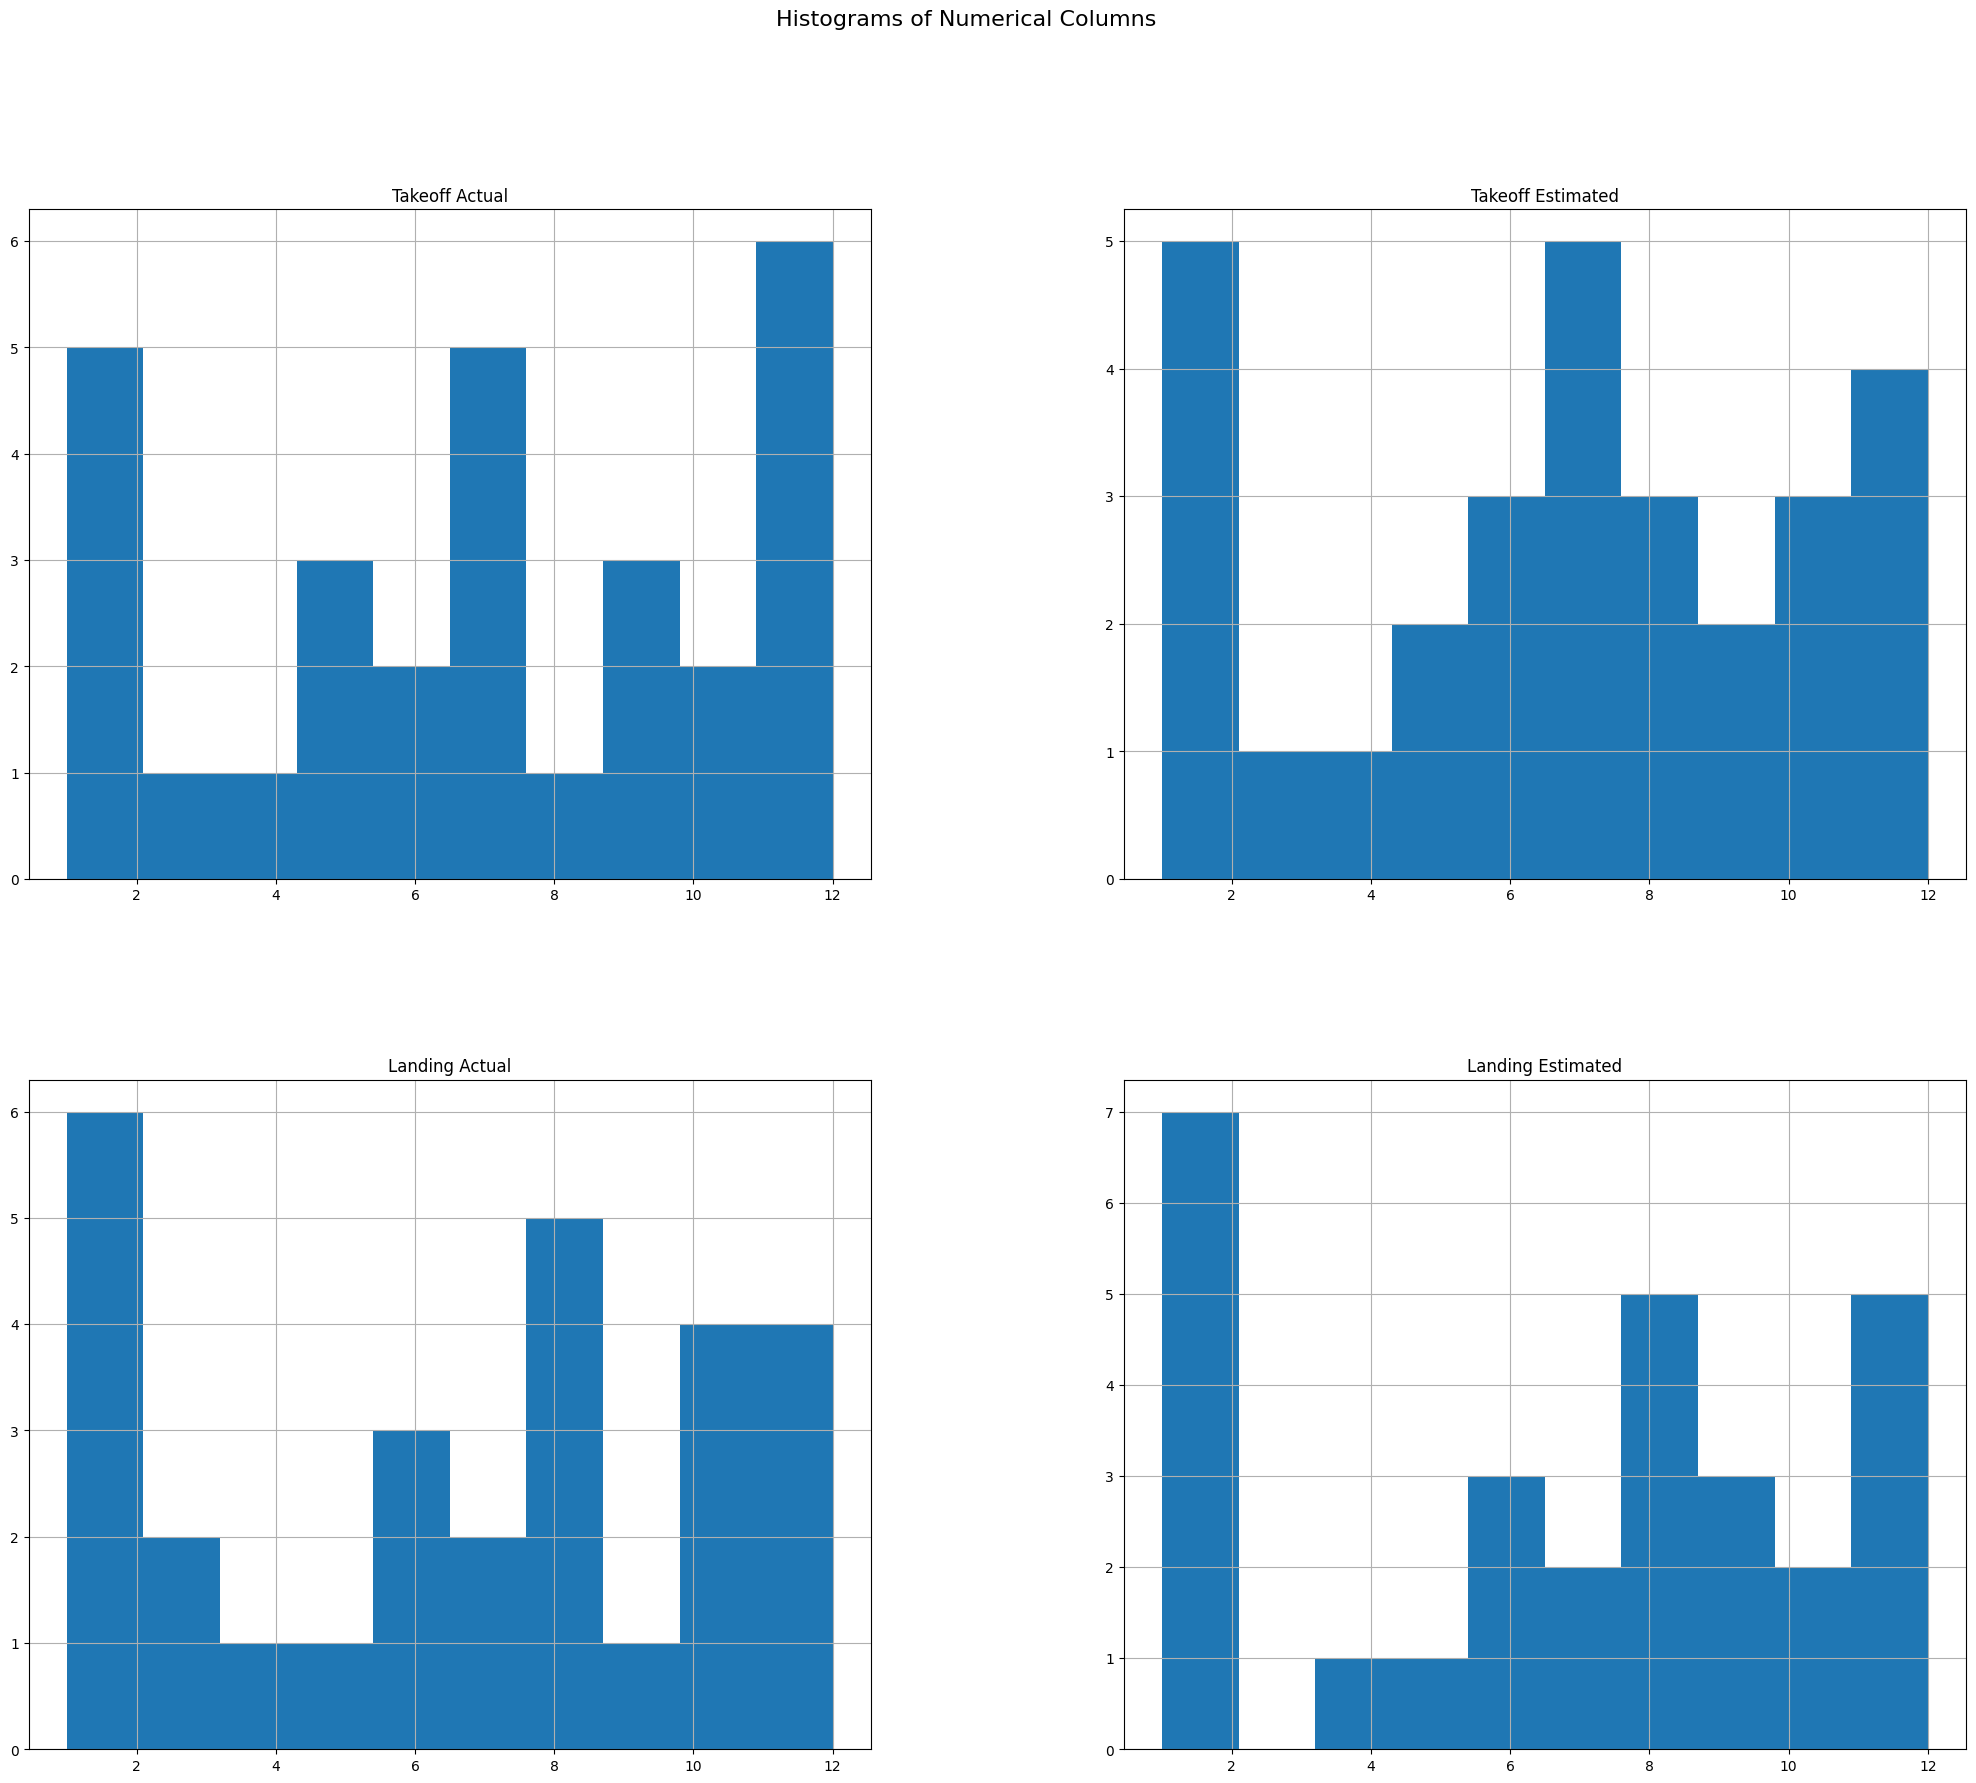

In [7]:
def clean_and_convert(column):
    # Convert column to string type
    column = column.astype(str)
    # Extract numerical values and handle ranges
    numerical_values = column.str.extract(r'(\d+)-?(\d*)')[0].astype(float)
    # For ranges, calculate the average
    range_end = column.str.extract(r'(\d+)-?(\d*)')[1].replace('', np.nan).astype(float)
    numerical_values += range_end.fillna(0) / 2
    
    # Replace any NaN values with -1 to indicate that the value could not be extracted
    numerical_values.fillna(-1, inplace=True)
    
    return numerical_values

# Clean and convert selected columns to numerical types
# columns_to_clean = ['Taxi Takeoff', 'Average Delay Takeoff', 'Gate Departure Actual', 
#                     'Gate Departure Estimated', 'Takeoff Actual', 'Takeoff Estimated',
#                     'Taxi Landing', 'Average Delay Landing', 'Landing Actual',
#                     'Landing Estimated', 'Gate Arrival Actual', 'Gate Arrival Estimated']
columns_to_clean = ['Takeoff Actual', 'Takeoff Estimated',
                     'Landing Actual','Landing Estimated']

for column in columns_to_clean:
    df[column] = clean_and_convert(df[column].copy())

# Plot histograms for all numerical columns
df[columns_to_clean].hist(figsize=(25, 20))
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.show()


## Data Preprocessing
### Creating Noise

In [8]:
# # Define the standard deviation for the noise 
# std_dev = 5  

# # Function to add noise to numerical columns in a DataFrame
# def add_noise(df, std_dev=1):
#     df_with_noise = df.copy()  # Create a copy of the original dataframe
#     for col in df_with_noise.columns[2:]:
#         noise = np.random.normal(0, std_dev, len(df))  # Use len(df) instead of len(data)
#         df_with_noise[col] += noise
#     return df_with_noise

# # Add noise to the numerical columns of the DataFrame with a standard deviation of 1
# df_with_noise = add_noise(df, std_dev=1)

# # Display the modified dataset
# print(df_with_noise)

## 

# Flight Model

In [9]:

# Columns to use for training
# columns_to_use = ['Taxi Takeoff', 'Average Delay Takeoff', 'Gate Departure Actual',
#                   'Gate Departure Estimated', 'Takeoff Actual', 'Takeoff Estimated',
#                   'Taxi Landing', 'Average Delay Landing', 'Landing Actual',
#                   'Landing Estimated', 'Gate Arrival Actual', 'Gate Arrival Estimated']
columns_to_use = ['Takeoff Actual', 'Takeoff Estimated',
                    'Landing Actual','Landing Estimated']
# Define features and target column
# features = ['Taxi Takeoff', 'Average Delay Takeoff', 'Gate Departure Actual', 
#             'Gate Departure Estimated', 'Takeoff Actual', 'Takeoff Estimated',
#             'Taxi Landing', 'Average Delay Landing', 'Landing Actual',
#             'Landing Estimated', 'Gate Arrival Actual', 'Gate Arrival Estimated']
features = ['Takeoff Actual', 'Takeoff Estimated',
                    'Landing Actual','Landing Estimated']
target = 'Landing Actual'

# Split the data into features (X) and target (y)
X = df[features]
y = df[target]

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree Model
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_acc_scores = cross_val_score(dt_classifier, X, y, cv=kf)

# Random Forest Model
rf_classifier = RandomForestClassifier(random_state=42)
rf_acc_scores = cross_val_score(rf_classifier, X, y, cv=kf)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)
rfreg_acc_scores = cross_val_score(rf_regressor, X, y, cv=kf)

l_regressor = LinearRegression()
lr_acc_scores = cross_val_score(l_regressor, X, y, cv=kf)

# Print the mean accuracy scores
print("Mean Accuracy Scores:")
print("Decision Tree Classifier:", np.mean(dt_acc_scores))
print("Random Forest Classifier:", np.mean(rf_acc_scores))
print("Random Forest Regressor:", np.mean(rfreg_acc_scores))
print("Linear Regressor:", np.mean(lr_acc_scores))





Mean Accuracy Scores:
Decision Tree Classifier: 0.6533333333333334
Random Forest Classifier: 0.7333333333333334
Random Forest Regressor: 0.91441759817651
Linear Regressor: 1.0


## Heatmap

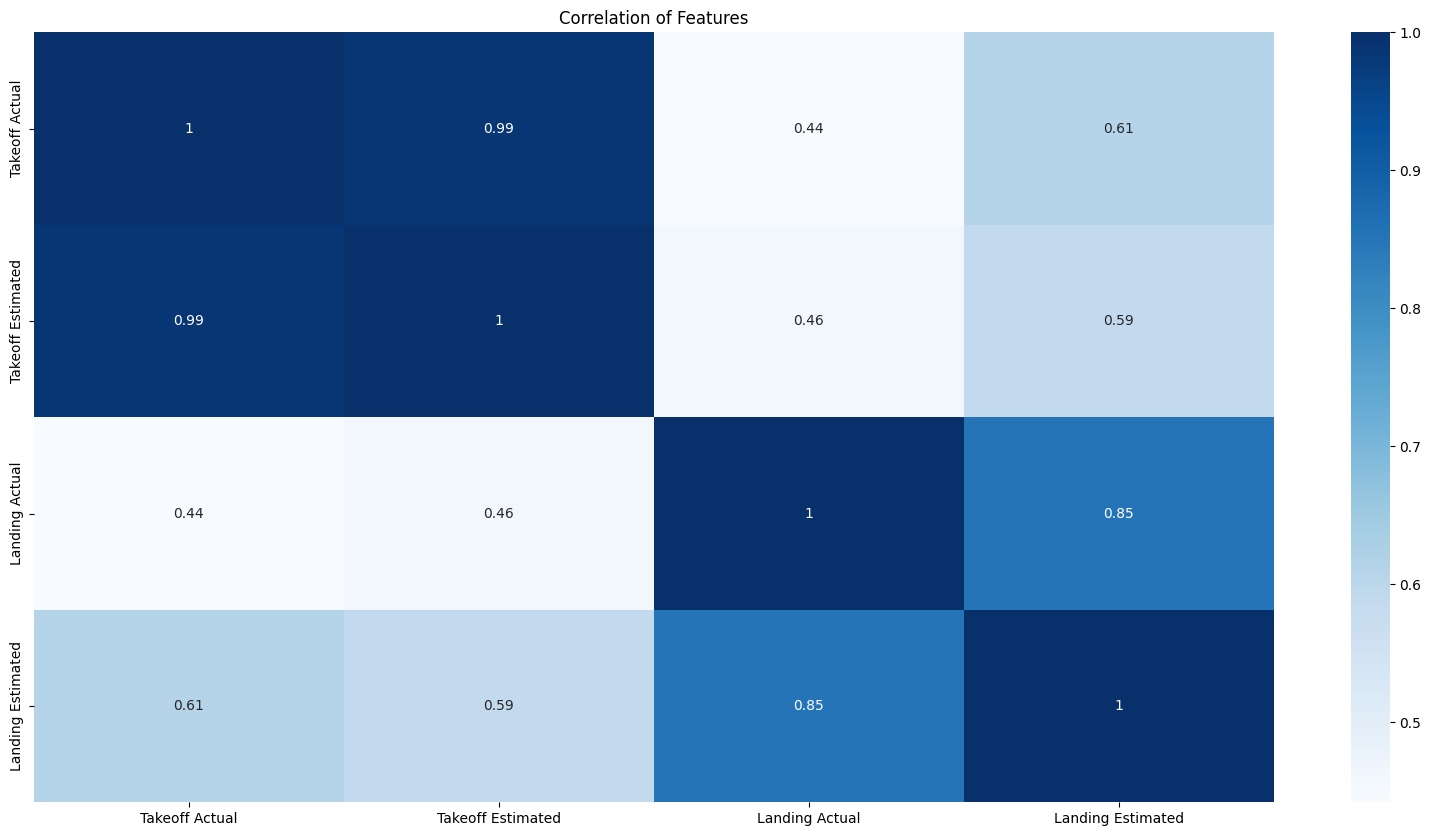

In [10]:
# Heatmap of the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(df[features].corr(), annot=True, cmap='Blues')
plt.title("Correlation of Features")
plt.show()

In [11]:

# Target column
target_column = 'Landing Actual'

# Splitting the data into features (X) and target variable (y)
X = df[columns_to_use]
y = df[target_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = RandomForestRegressor()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1542833333333333


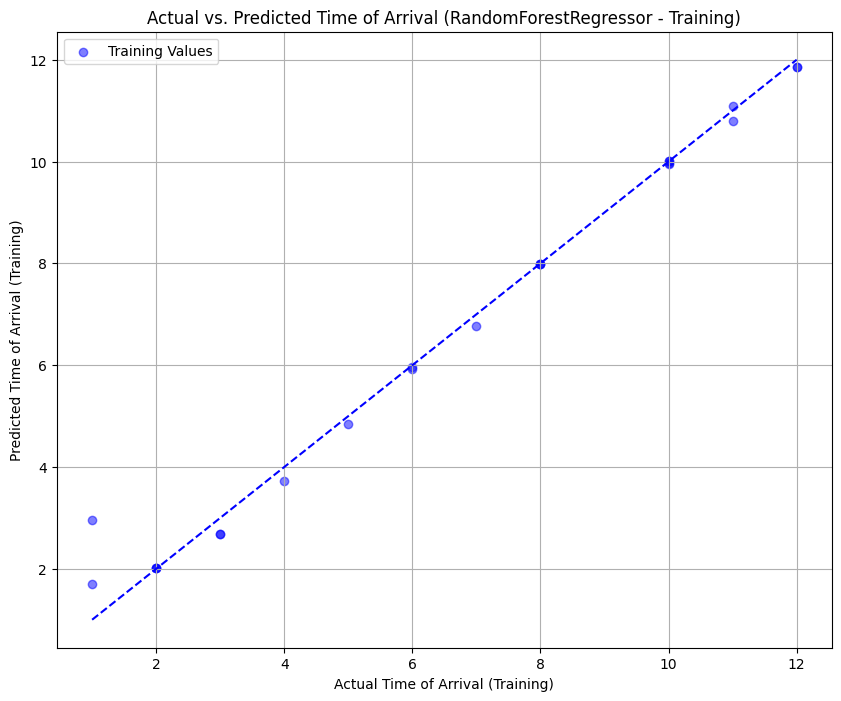

In [12]:
# Fit RandomForestRegressor on the training data
rf_regressor.fit(X_train, y_train)

# Plot actual vs. predicted values for training data
plt.figure(figsize=(10, 8))
plt.scatter(y_train, rf_regressor.predict(X_train), color='blue', alpha=0.5, label='Training Values')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='blue')  # Diagonal line
plt.xlabel("Actual Time of Arrival (Training)")
plt.ylabel("Predicted Time of Arrival (Training)")
plt.title("Actual vs. Predicted Time of Arrival (RandomForestRegressor - Training)")
plt.legend()
plt.grid(True)
plt.show()


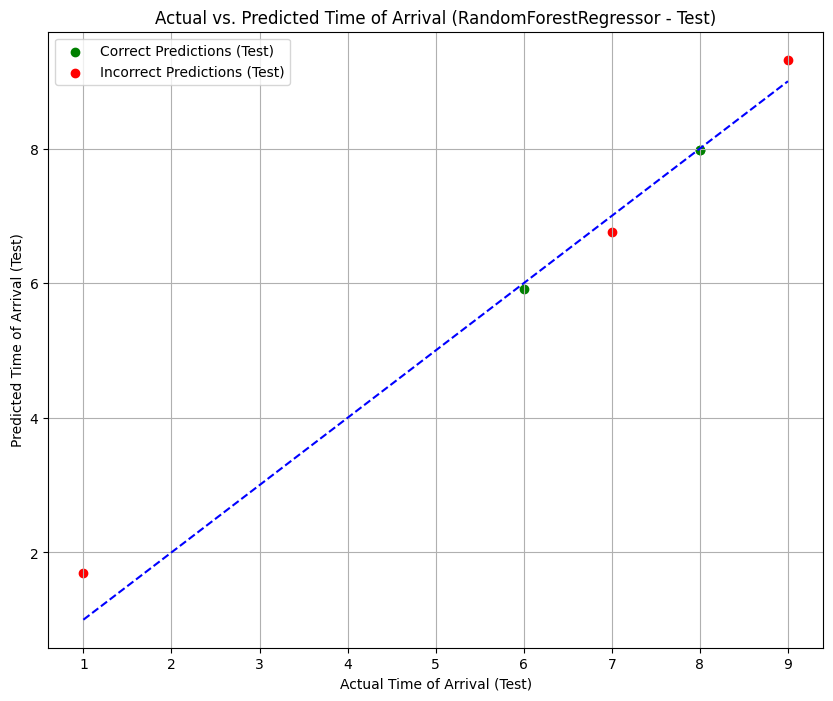

In [13]:
# Define threshold for acceptable error
threshold = 0.1

# Fit RandomForestRegressor on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = rf_regressor.predict(X_test)

# Calculate absolute error
absolute_error = np.abs(y_test - y_pred_rf)

# Determine if each prediction is within the threshold
correct_predictions = absolute_error <= threshold

# Plot actual vs. predicted values for test data, color coding based on correctness
plt.figure(figsize=(10, 8))
plt.scatter(y_test[correct_predictions], y_pred_rf[correct_predictions], color='green', label='Correct Predictions (Test)')
plt.scatter(y_test[~correct_predictions], y_pred_rf[~correct_predictions], color='red', label='Incorrect Predictions (Test)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='blue')  # Diagonal line
plt.xlabel("Actual Time of Arrival (Test)")
plt.ylabel("Predicted Time of Arrival (Test)")
plt.title("Actual vs. Predicted Time of Arrival (RandomForestRegressor - Test)")
plt.legend()
plt.grid(True)
plt.show()

## Importance of features in the RF Regressor

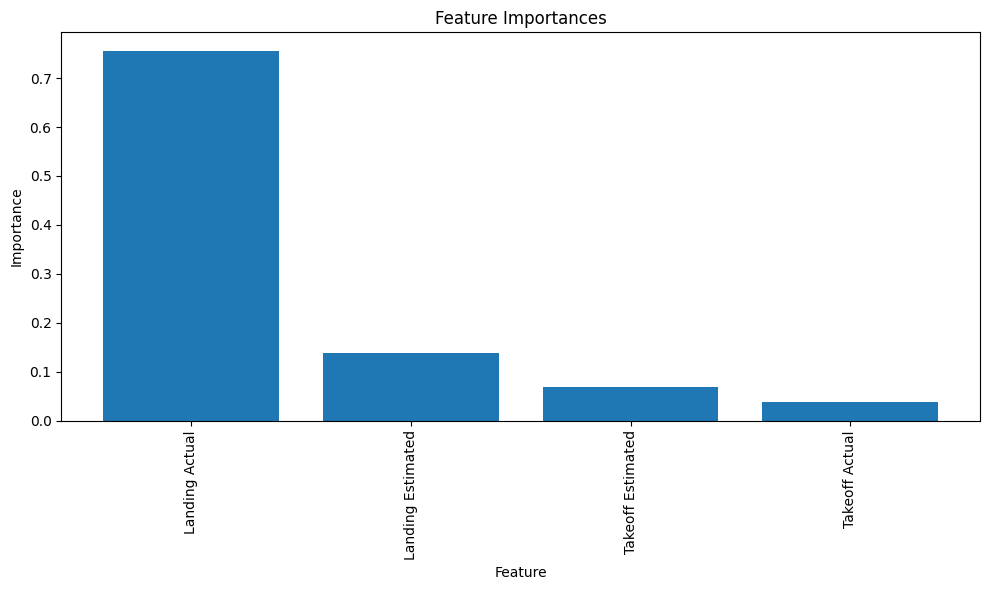

In [14]:
# Fit RandomForestRegressor on the training data
rf_regressor.fit(X_train, y_train)

# Get feature importances
importances = rf_regressor.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


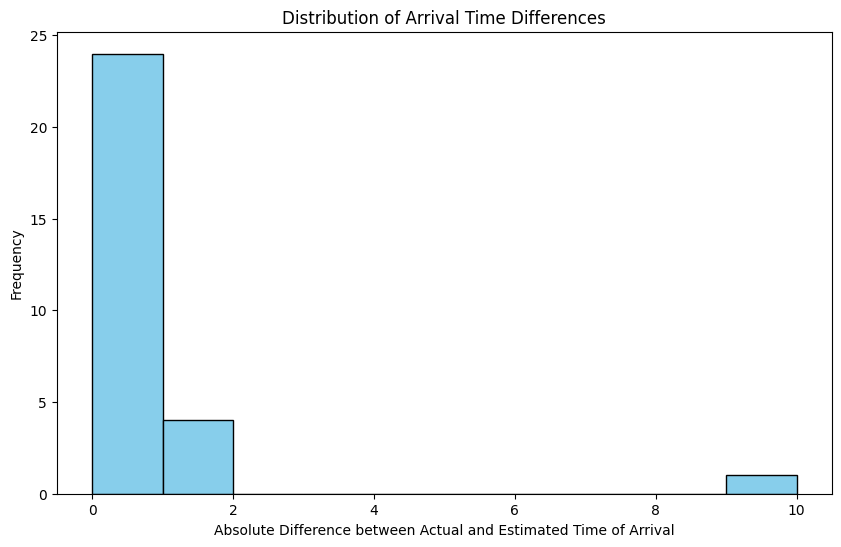

Mean difference: 0.4827586206896552
Maximum difference: 10.0
Minimum difference: 0.0


In [15]:
# Calculate the absolute difference between actual and estimated time of arrival
df['Arrival_Time_Difference'] = np.abs(df['Landing Actual'] - df['Landing Estimated'])

# Visualize the difference
plt.figure(figsize=(10, 6))
plt.hist(df['Arrival_Time_Difference'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Absolute Difference between Actual and Estimated Time of Arrival')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Time Differences')
plt.show()

# Analyze the difference
mean_difference = df['Arrival_Time_Difference'].mean()
max_difference = df['Arrival_Time_Difference'].max()
min_difference = df['Arrival_Time_Difference'].min()

print("Mean difference:", mean_difference)
print("Maximum difference:", max_difference)
print("Minimum difference:", min_difference)
